# Word2Vec

Let's work on skipgram-based implementation of word2vec.

# 0. Importing Libaries

In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import datetime

# 1. Importing and Preparing Dataset

### Downloading nltk dataset

In [56]:
import nltk
nltk.download('reuters')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('abc')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package abc to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package abc is already up-to-date!


True

### Import Australian Broadcasting Corporation (ABC) news for training

In [57]:
from nltk.corpus import abc
abc.words()

['PM', 'denies', 'knowledge', 'of', 'AWB', 'kickbacks', ...]

In [58]:
# .sents() returns sentences already tokenized
corpus = abc.sents()
len(corpus)

29059

In [59]:
len(corpus[5])

27

In [60]:
# Limiting the corpus to only 5000 documents since using the entire corpus
# is not feasible with available computational resources
corpus = corpus[0:5000]

In [61]:
len(corpus)

5000

In [62]:
# Convert all characters to lowercase to handle case sensitivity
corpus = [[word.lower() for word in sent] for sent in corpus]

In [63]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [64]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [65]:
#vocab size
voc_size = len(vocab)
print(voc_size)

9774


In [66]:
#append UNK
vocab.append('<UNK>')

In [67]:
word2index['<UNK>'] = voc_size # since current word2index[0:voc_size-1]

In [68]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

In [69]:
#vocab size
voc_size = len(vocab)
print(voc_size)

9775


# 2. Prepare train data

In [70]:
#check token count
wc = 0
for i in range(len(corpus)):
    wc += len(corpus[i])

In [71]:
wc

134349

In [72]:
for c in corpus:
    print(c)

['pm', 'denies', 'knowledge', 'of', 'awb', 'kickbacks', 'the', 'prime', 'minister', 'has', 'denied', 'he', 'knew', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'despite', 'writing', 'to', 'the', 'wheat', 'exporter', 'asking', 'to', 'be', 'kept', 'fully', 'informed', 'on', 'iraq', 'wheat', 'sales', '.']
['letters', 'from', 'john', 'howard', 'and', 'deputy', 'prime', 'minister', 'mark', 'vaile', 'to', 'awb', 'have', 'been', 'released', 'by', 'the', 'cole', 'inquiry', 'into', 'the', 'oil', 'for', 'food', 'program', '.']
['in', 'one', 'of', 'the', 'letters', 'mr', 'howard', 'asks', 'awb', 'managing', 'director', 'andrew', 'lindberg', 'to', 'remain', 'in', 'close', 'contact', 'with', 'the', 'government', 'on', 'iraq', 'wheat', 'sales', '.']
['the', 'opposition', "'", 's', 'gavan', 'o', "'", 'connor', 'says', 'the', 'letter', 'was', 'sent', 'in', '2002', ',', 'the', 'same', 'time', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'though', 'a', 'jordanian', 'trucking', 'company', '.'

In [73]:
# Batching function
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of two size window
    skip_grams = []
    # loop each word sequence
    # we starts from 2 because 0 has no context (window size = 2)
    # we stop at third last for the same reason
    for sent in word_sequence:
        for i in range(2, len(sent) - 2):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 2]], word2index[sent[i - 1]],
                       word2index[sent[i + 1]], word2index[sent[i + 2]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [74]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ",  input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[7183]
 [3102]]
Target:  [[1987]
 [7588]]


In [75]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 3. Model

In [76]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs = all_vocabs.to(device) # send vocabs to GPU
all_vocabs.shape

torch.Size([2, 9775])

## 4. Training

In [78]:
batch_size     = 2 # mini-batch size
embedding_size = 50 #  according to word2vec paper 50-300
model          = Skipgram(voc_size, embedding_size)
model = model.to(device) # send model to GPU


optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time, elapsed_mins, elapsed_secs

In [80]:
import time

# Training
# Since our training data is small, 1000 epochs instead of between 3 and 50 as per the paper
num_epochs = 1000
total_time = 0 # Store total training time
losses = [] # Store losses over training
start = time.time()
for epoch in range(num_epochs):
    
    
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    optimizer.zero_grad()
    
    loss = model(input_batch, target_batch, all_vocabs)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        end = time.time()
        total, epoch_mins, epoch_secs = epoch_time(start, end)
        total_time += total
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        start = time.time()


Epoch: 100 | cost: 27.409861 | time: 0m 43s
Epoch: 200 | cost: 34.451225 | time: 0m 38s
Epoch: 300 | cost: 29.494099 | time: 0m 39s
Epoch: 400 | cost: 28.018015 | time: 0m 39s
Epoch: 500 | cost: 25.836599 | time: 0m 39s
Epoch: 600 | cost: 29.150671 | time: 0m 39s
Epoch: 700 | cost: 29.154118 | time: 0m 40s
Epoch: 800 | cost: 28.052504 | time: 0m 40s
Epoch: 900 | cost: 23.960314 | time: 0m 39s
Epoch: 1000 | cost: 24.101730 | time: 0m 39s


In [81]:
print(f'Training Loss: {loss}, Training Time: {str(datetime.timedelta(seconds=total_time))}')

Training Loss: 24.101730346679688, Training Time: 0:06:40.279924


In [82]:
# Saving the model for testing
torch.save(model.state_dict(), 'app/models/Skipgram-v1.pt')

In [83]:
Data = {
    'corpus': corpus,
    'vocab': vocab,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': embedding_size
}

In [84]:
pickle.dump(Data,open('./app/models/Data.pkl', 'wb'))

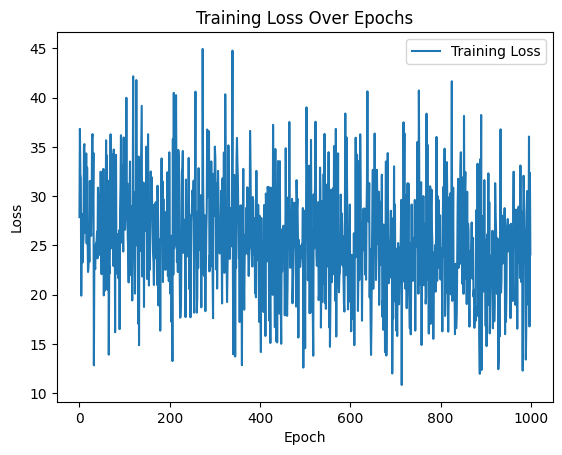

In [85]:
# Extract the numerical values from the tensors
loss_values = [loss.item() for loss in losses]

# Plot the losses
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## 5. Plotting the embeddings

In [86]:
#list of vocabs
vocab[:10]

['data',
 'kingsford',
 'sliding',
 'trends',
 'ritchie',
 'accessing',
 'orica',
 'reading',
 'financially',
 'bertram']

In [87]:
word = vocab[0]

In [88]:
#numericalization
id = word2index[word]
id

0

In [89]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [90]:
# Move id_tensor to the same device as the model
id_tensor = id_tensor.to(device)

# Get the embedding
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed


(tensor([[ 1.1654,  0.6181,  0.1854, -0.5736,  0.1170,  0.6825,  0.1372, -0.9253,
           0.8611, -0.0471,  1.4180, -0.4399, -0.4953, -1.7206,  0.0450, -0.4595,
           0.2636,  0.7543,  1.0716,  1.4679, -1.6561, -2.1246, -1.2770, -1.6193,
          -1.4079,  0.5954, -1.5210,  0.4834, -0.5800, -0.8599,  2.4341, -1.1427,
          -0.4492,  1.3209, -1.5219,  2.0184,  0.5862, -0.8525,  0.9623, -1.3458,
           0.3805, -1.3932, -0.2839,  0.3192,  0.1751, -0.0220, -0.2342, -0.4622,
          -0.7816, -1.1714]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[-1.2115,  0.8437, -0.5738, -1.0174,  0.2802, -0.0986, -1.5922,  1.1560,
           0.4527,  1.3908,  0.3066, -1.3043,  1.0837, -1.4292,  0.6033,  0.0702,
           2.5074,  0.3018,  0.3947, -1.1694,  1.7544,  0.3692, -0.1237,  0.7801,
           0.3841, -1.3982, -1.0851,  0.9415, -1.2361,  1.5509, -0.3426, -0.5057,
           0.1834, -1.6603,  0.8192, -0.3376,  1.6269,  0.4391, -0.0703, -0.1482,
           0.2275,  

In [91]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.7309, device='cuda:0', grad_fn=<SelectBackward0>)

In [92]:
from sklearn.decomposition import PCA

# Perform PCA to reduce embeddings to 2D
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)  # Ensure on the correct device
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2  # Average the embeddings
    return word_embed.cpu().detach().numpy()  # Return the embedding as a NumPy array

# Apply PCA to reduce the dimensionality of all embeddings
def reduce_embeddings_to_2D(vocab):
    embeddings = [get_embed(word) for word in vocab[:20]]  # Get embeddings for the first 20 words
    embeddings = np.vstack(embeddings)  # Combine into a matrix
    pca = PCA(n_components=2)  # Reduce to 2D
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings



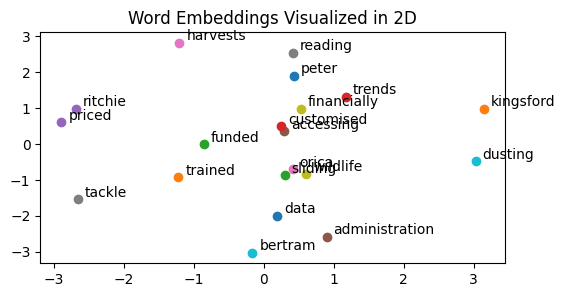

In [93]:
import matplotlib.pyplot as plt

reduced_embeddings = reduce_embeddings_to_2D(vocab)

plt.figure(figsize=(6, 3))
for i, word in enumerate(vocab[:20]):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

plt.title("Word Embeddings Visualized in 2D")
plt.show()


## 6. Cosine similarity

In [94]:
vocab

['data',
 'kingsford',
 'sliding',
 'trends',
 'ritchie',
 'accessing',
 'orica',
 'reading',
 'financially',
 'bertram',
 'peter',
 'trained',
 'funded',
 'customised',
 'priced',
 'administration',
 'harvests',
 'tackle',
 'wildlife',
 'dusting',
 'loss',
 'broke',
 'reaches',
 'willis',
 'cost',
 'monks',
 'prioritisation',
 'merits',
 'chairwoman',
 'mccallum',
 'toad',
 'heidrich',
 'caring',
 'navy',
 'glass',
 'construct',
 'qualities',
 'shareholders',
 'knots',
 'prizemoney',
 'hastily',
 'hatchlings',
 'commercial',
 'birds',
 'suspended',
 'blight',
 'habitat',
 'mauritius',
 'enthusiast',
 'allocating',
 'excuse',
 'contains',
 'peglar',
 'mccain',
 'stress',
 'victim',
 'mushroom',
 '2005',
 'messages',
 'clearing',
 'us37',
 'approve',
 'implore',
 'senses',
 'took',
 'aground',
 'harvested',
 'ruled',
 'detract',
 'trait',
 'everybody',
 'grant',
 'burnett',
 'evacuees',
 'as',
 'tennant',
 'regatta',
 'terrorism',
 "/'",
 'brazil',
 'giving',
 'says',
 'liquefying',
 'p

In [95]:
#let's try similarity between first and second, and second and third
saviour         = get_embed('saviour')
made        = get_embed('made')
avoid       = get_embed('avoid')

In [96]:
import numpy as np
from numpy.linalg import norm

def cos_sim(a, b):
    # Flatten the vectors to ensure they are 1D
    a = a.flatten()
    b = b.flatten()
    # Calculate cosine similarity
    cos_sim = np.dot(a, b) / (norm(a) * norm(b))
    return cos_sim


In [97]:
# Example vectors (replace with actual embeddings)
saviour = np.random.rand(1, 100)  # Example embedding of shape (1, 100)
made = np.random.rand(1, 100)
avoid = np.random.rand(1, 100)

# Compute cosine similarities
print(f"saviour vs. made: ", cos_sim(saviour, made))
print(f"saviour vs. avoid: ", cos_sim(saviour, avoid))
print(f"saviour vs. saviour: ", cos_sim(saviour, saviour))


saviour vs. made:  0.7434448033562141
saviour vs. avoid:  0.7635512499051578
saviour vs. saviour:  1.0


In [98]:
from scipy.spatial import distance

def cos_sim(a, b):
    # Ensure the inputs are 1D arrays
    a = a.flatten()  # Flatten to 1D
    b = b.flatten()  # Flatten to 1D
    # Compute cosine similarity
    cos_sim = 1 - distance.cosine(a, b)  # 1 - distance gives similarity
    return cos_sim

# Example vectors (replace these with actual embeddings)
saviour = np.random.rand(1, 100)  # Example embedding of shape (1, 100)
made = np.random.rand(1, 100)
avoid = np.random.rand(1, 100)

# Compute cosine similarities
print(f"saviour vs. made: {cos_sim(saviour, made)}")
print(f"saviour vs. avoid: {cos_sim(saviour, avoid)}")
print(f"saviour vs. saviour: {cos_sim(saviour, saviour)}")


saviour vs. made: 0.7335058546061951
saviour vs. avoid: 0.7299686275071604
saviour vs. saviour: 1.0
